## (Draft!) Train experiments with an autoencoder as DR

In [1]:
%load_ext autoreload
%autoreload 2

## Initialization

Imports

In [2]:
import sys
sys.path.append('../')

import torch
from torch import nn
import matplotlib.pyplot as plt

# local imports
from setup import setup_device, setup_datamodule, load_model
from adapters.main import capture_conv_layers
from dimensionality_reduction.feature_autoencoder import FeatureAutoencoder



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

nnUNet_raw_data_base is not defined and nnU-Net can only be used on data for which preprocessed files are already present on your system. nnU-Net cannot be used for experiment planning and preprocessing like this. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up properly.
nnUNet_preprocessed is not defined and nnU-Net can not be used for preprocessing or training. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up.
RESULTS_FOLDER is not defined and nnU-Net cannot be used for training or inference. If this is not in

Set the device globally

In [3]:
device = setup_device('cuda:2')
print(device, type(device))

cuda:2 <class 'torch.device'>


Load a trained model

In [4]:
model = load_model('../pre-trained/trained_UNets/mnmv2-00-02_22-11-2024-v1.ckpt', device)

Loaded as Lightning module


Initialize mnmv2 dataset module

In [5]:
datamodule = setup_datamodule()

In [ ]:
# for idx, data_batch in enumerate(iter(datamodule.val_dataloader())):
#     print(idx, data_batch['input'].size(), data_batch['target'].size())
#     # size format: [batch size, channels, width, hegiht]
#     # next sample: data_sample = next(iter(datamodule.val_dataloader()))['input']

In [27]:
# no. of epochs for training
EPOCHS_COUNT = 100

# output dims of dim reduction
OUT_DIMS = 3

# display results for a selected sample
SAMPLE_ID = 5

In [8]:
# LAYER_ID = 10
LAYER_ID = 110

### Preparation

Take the first batch from the datamodule

In [9]:
data_batch = next(iter(datamodule.val_dataloader()))

data_sample = data_batch['input']
data_sample.size() # [batch size, channels, width, hegiht]

torch.Size([32, 1, 256, 256])

Use hooks to capture hidden layer activations in the batch

In [10]:
wrapper, layer_names = capture_conv_layers(model, device, data_sample)

In [11]:
layer_samples = wrapper.layer_activations[layer_names[LAYER_ID]]

print(f"shape of the selected layer ([COUNT, C, H, W]): {layer_samples.size()}")

shape of the selected layer ([COUNT, C, H, W]): torch.Size([32, 16, 128, 128])


In [12]:
BATCH_COUNT, C, H, W = layer_samples.detach().numpy().shape

## Experiments (single & batch)

Define a train function

In [13]:
def train_batch(autoencoder, num_epochs: int, samples):
    epoch_loss = .0
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)
    for epoch in range(num_epochs):
        for image in samples:
            latent, reconstructed = autoencoder(image)
            loss = criterion(reconstructed, image)
            optimizer.zero_grad() # reset gradients

            epoch_loss += loss.item()

            loss.backward()
            optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(samples):.4f}")

    return autoencoder


Define visualization functions:

In [14]:
def visualize(image):
    if image.shape[0] > 3:  # If more than 3 channels, average channels
        # return image.mean(axis=0)
        return image[0]
    else:  # If 3 or fewer channels, just transpose to match image format
        return image.transpose(1, 2, 0)  # [C, H, W] -> [H, W, C]

In [15]:
def plot_results(orig, reconstr, latent):
    # Create a side-by-side plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Original Image
    axes[0].imshow(visualize(orig), cmap='gray')
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # Reconstructed Image
    axes[1].imshow(visualize(reconstr), cmap='gray')
    axes[1].set_title("Reconstructed Image")
    axes[1].axis("off")

    # Latent Representation (3 channels, like RGB)
    axes[2].imshow(latent.transpose(1, 2, 0))  # Transpose for [H, W, C]
    axes[2].set_title("Latent Representation")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

torch.Size([1, 256, 256])


(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

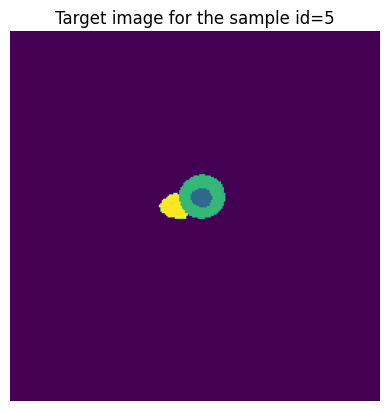

In [28]:
data_sample_target = data_batch['target'][SAMPLE_ID]
print(data_sample_target.size())

plt.imshow(data_sample_target.detach().numpy().transpose(1, 2, 0))
plt.title(f'Target image for the sample id={SAMPLE_ID}')
plt.axis("off")

### Single Layer Training

Create an instance of Autoencoder for training

In [17]:
BATCH_COUNT, C, H, W = layer_samples.detach().numpy().shape

autoencoder = FeatureAutoencoder(C, OUT_DIMS)

defined an autoencoder with input channels=16 and out channels=3


In [18]:
autoencoder = train_batch(autoencoder, EPOCHS_COUNT, [layer_samples[SAMPLE_ID]])

Epoch [100/100], Loss: 13.0062


Show the results

In [44]:
selected_sample = layer_samples[SAMPLE_ID]
latent, reconstructed = autoencoder(selected_sample)

In [45]:
original_np = selected_sample.detach().numpy()
latent_np = latent.detach().numpy()
reconstructed_np = reconstructed.detach().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9677908..1.6646497].


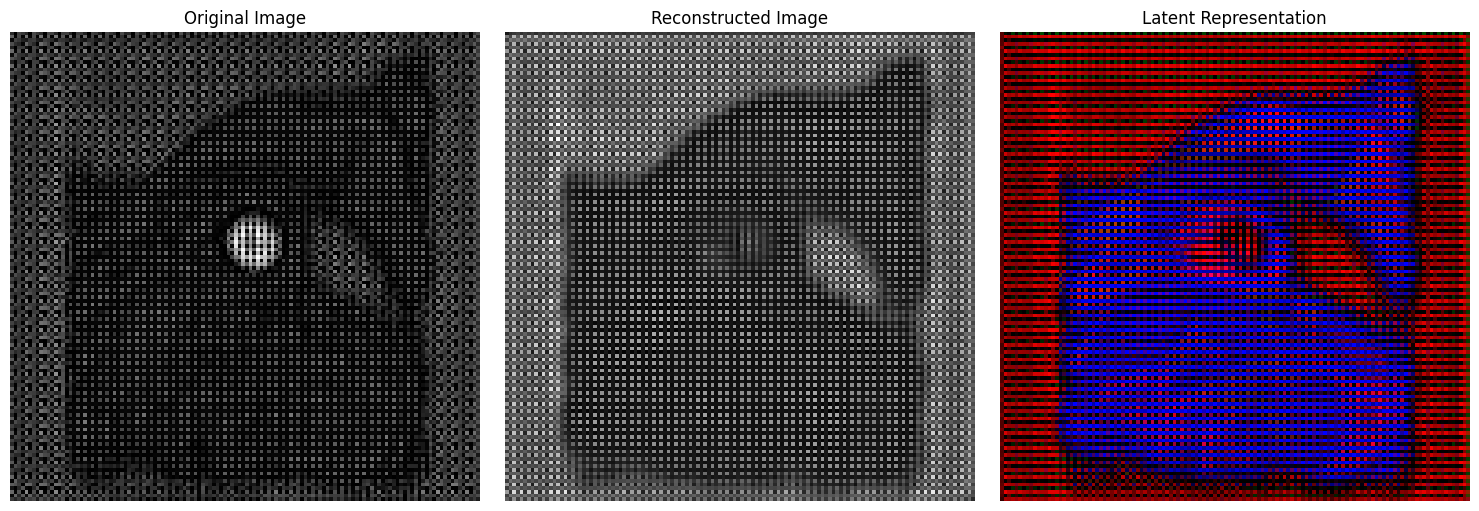

In [31]:
plot_results(original_np, reconstructed_np, latent_np)

In [46]:
import numpy as np

mse_error = np.mean((original_np - reconstructed_np) ** 2)

print(f"MSE Error: {mse_error.item()}")


MSE Error: 0.07001526653766632


### Single Batch Training

In [22]:
BATCH_COUNT, C, H, W = layer_samples.detach().numpy().shape

autoencoder_batch = FeatureAutoencoder(C, OUT_DIMS)

defined an autoencoder with input channels=16 and out channels=3


In [23]:
autoencoder_batch = train_batch(autoencoder_batch, EPOCHS_COUNT, layer_samples)

Epoch [100/100], Loss: 1.9619


Show the results

In [32]:
selected_sample = layer_samples[SAMPLE_ID]
latent_batch, reconstructed_batch = autoencoder_batch(selected_sample)

In [33]:
original_batch_np = selected_sample.detach().numpy()
latent_batch_np = latent_batch.detach().numpy()
reconstructed_batch_np = reconstructed_batch.detach().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.76603..4.9789].


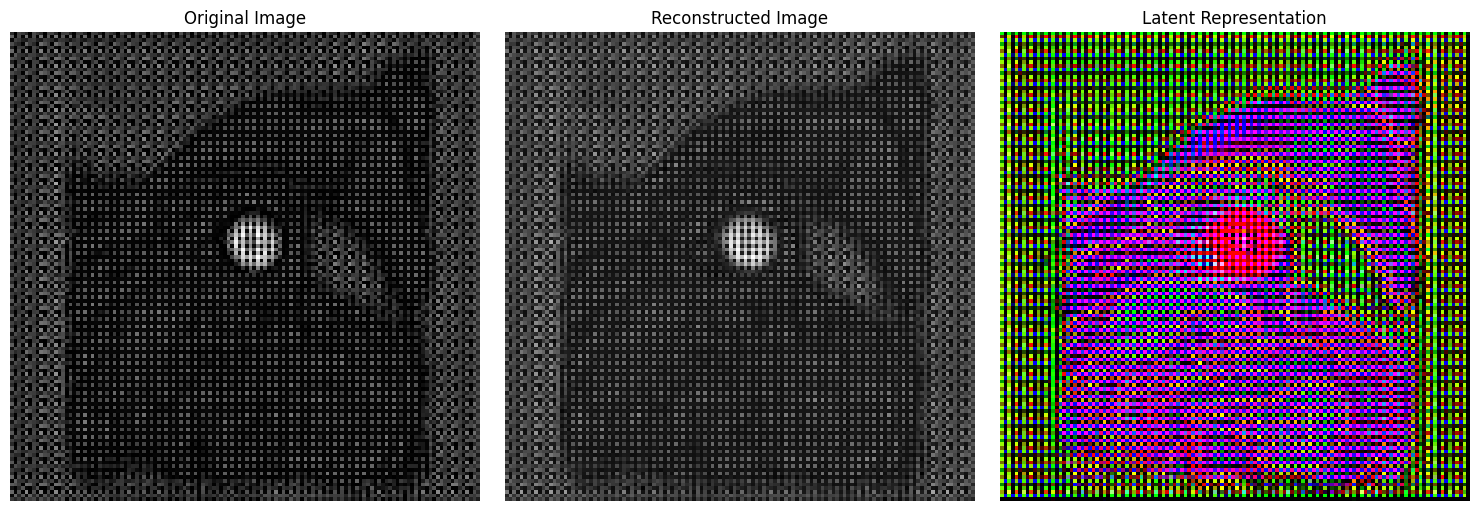

In [34]:
plot_results(original_batch_np, reconstructed_batch_np, latent_batch_np)

In [48]:
mse_error = np.mean((original_np - reconstructed_batch_np) ** 2)

print(f"MSE Error: {mse_error.item()}")

MSE Error: 0.008745979517698288


#### Conclusions
An autoencoder trained on a batch instead of a single image provides a more accurate representation (the borders are more properly defined and correspond to the target) of the layer and also a better reconstruction with a smaller loss.

=> let's try to perform training on a whole dataset and compare the results there as well.

## Whole Dataset Training

In [37]:
from dimensionality_reduction.save_utils import save_autoencoder_config, load_autoencoder_config

### Train new autoencoded

In [6]:
from dimensionality_reduction.train import train_dr

In [17]:
autoencoder_dataset = FeatureAutoencoder(C, OUT_DIMS)

defined an autoencoder with input channels=16 and out channels=3


In [22]:
autoencoder = train_dr(autoencoder=autoencoder_dataset, datamodule=datamodule, model=model, device=device, layer_id=LAYER_ID, num_epochs=EPOCHS_COUNT)

Epoch [1/100], Loss: 0.3484
Epoch [2/100], Loss: 0.6153
Epoch [3/100], Loss: 0.8498
Epoch [4/100], Loss: 1.0625
Epoch [5/100], Loss: 1.2612
Epoch [6/100], Loss: 1.4495
Epoch [7/100], Loss: 1.6301
Epoch [8/100], Loss: 1.8048
Epoch [9/100], Loss: 1.9740
Epoch [10/100], Loss: 2.1390
Epoch [11/100], Loss: 2.3006
Epoch [12/100], Loss: 2.4585
Epoch [13/100], Loss: 2.6139
Epoch [14/100], Loss: 2.7664
Epoch [15/100], Loss: 2.9162
Epoch [16/100], Loss: 3.0642
Epoch [17/100], Loss: 3.2105
Epoch [18/100], Loss: 3.3548
Epoch [19/100], Loss: 3.4969
Epoch [20/100], Loss: 3.6377
Epoch [21/100], Loss: 3.7768
Epoch [22/100], Loss: 3.9153
Epoch [23/100], Loss: 4.0515
Epoch [24/100], Loss: 4.1876
Epoch [25/100], Loss: 4.3218
Epoch [26/100], Loss: 4.4558
Epoch [27/100], Loss: 4.5879
Epoch [28/100], Loss: 4.7197
Epoch [29/100], Loss: 4.8503
Epoch [30/100], Loss: 4.9801
Epoch [31/100], Loss: 5.1088
Epoch [32/100], Loss: 5.2366
Epoch [33/100], Loss: 5.3637
Epoch [34/100], Loss: 5.4895
Epoch [35/100], Loss: 5

In [25]:
selected_sample = layer_samples[SAMPLE_ID]
original_np = selected_sample.detach().numpy()

In [27]:
latent, reconstructed = autoencoder(selected_sample)
latent_np = latent.detach().numpy()
reconstructed_np = reconstructed.detach().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.172372..2.6772187].


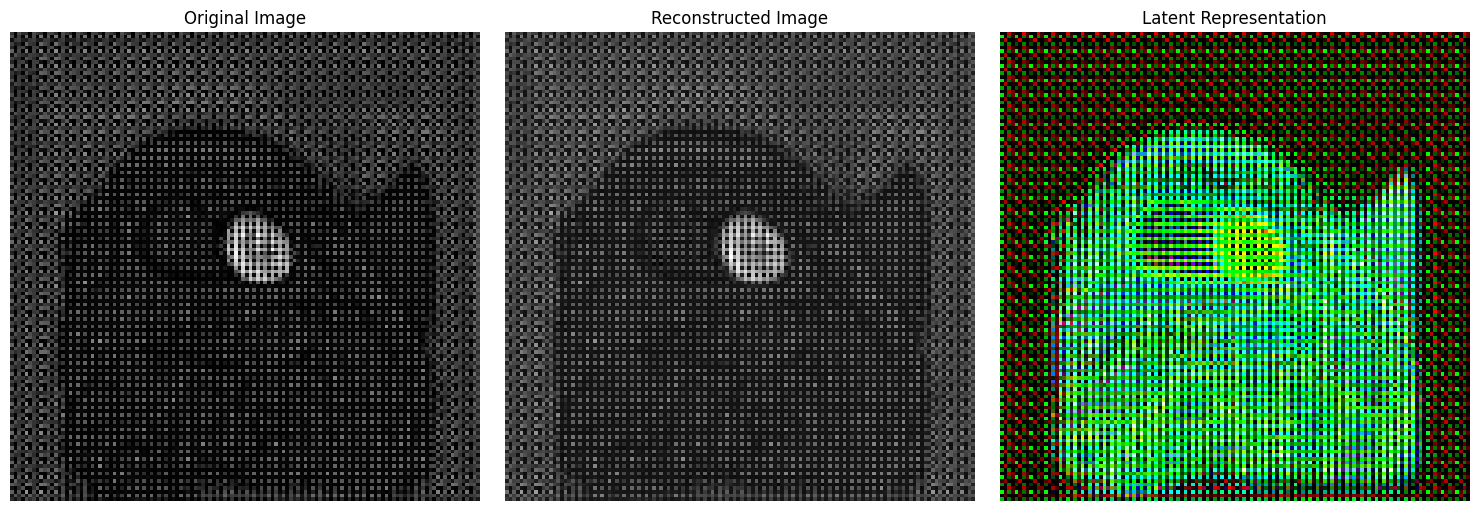

In [28]:
plot_results(original_np, reconstructed_np, latent_np)

In [ ]:
save_autoencoder_config(autoencoder, LAYER_ID)

Autoencoder saved to autoencoder_layer_110.pth


### Load saved autoencoder

In [38]:
# Initialize the same autoencoder structure
autoencoder_saved = FeatureAutoencoder(C, OUT_DIMS)
load_autoencoder_config(autoencoder_saved, LAYER_ID)

defined an autoencoder with input channels=16 and out channels=3
Autoencoder loaded successfully


/home/keller/repos/MedImSeg-Lab24/src/dimensionality_reduction/../dimensionality_reduction/save_utils.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_s

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.7874513..2.590176].


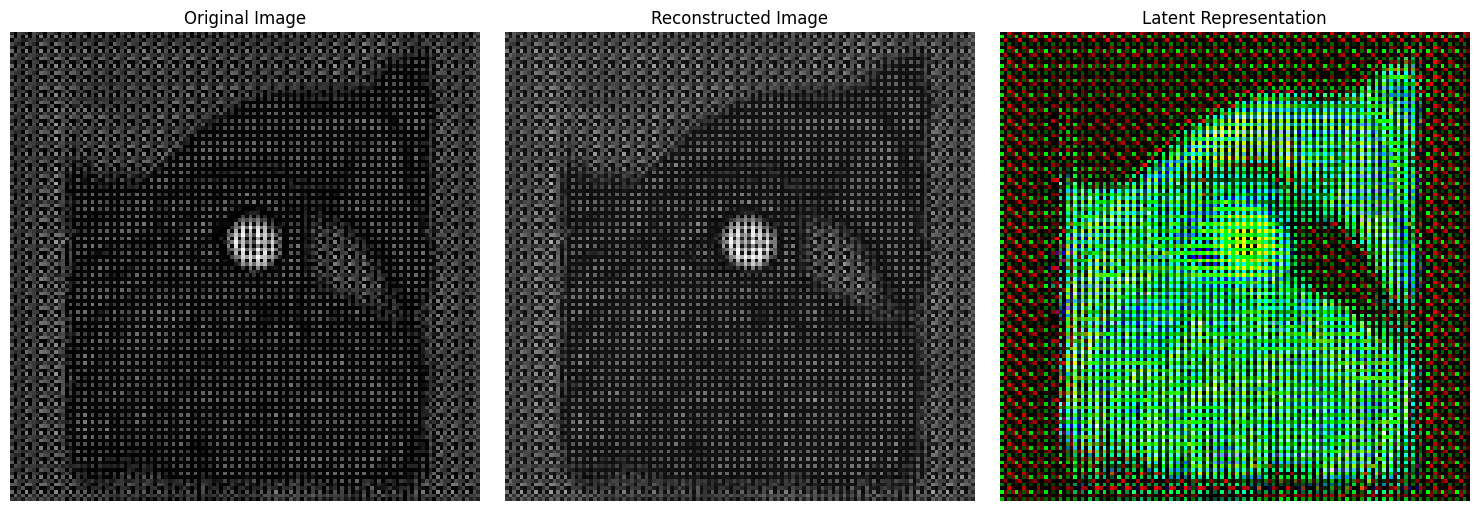

In [39]:
latent, reconstructed = autoencoder_saved(selected_sample)
latent_np = latent.detach().numpy()
reconstructed_np = reconstructed.detach().numpy()
plot_results(original_np, reconstructed_np, latent_np)

In [42]:
mse_error = np.mean((original_np - reconstructed_np) ** 2)

print(f"MSE Error: {mse_error.item()}")


MSE Error: 0.00452662305906415
